# WRITER RECOGNITION EVALUATION NOTEBOOK

We have trained two different classification models in the last notebook that were able to classify an image among 31 different authors. But In biometrics, we need feature extractor modules in order to create and extract the relevant features during the enrollment and save them in our gallery. Therefore, what we are going to do in this notebook is to remove the last layer of our model which is the classification layer in order to access the feature layer.
Then once we have the feature extractor model, we will perform the all-against-all methods in order to stress the system evaluation.

## PREPARATION
In the following, we are going to set some constants in order to use them during the evaluation. We also have mounting google drive in order to save the training logs into our g-drive.

### MOUNTING GOOGLE DRIVE
The first thing to do is to give google colab permission to access our drive so as to save the training checkpoints.

In [ ]:
#MOUNTING GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/gdrive',  force_remount=True)

Mounted at /content/gdrive


### DOWNLOAD The DATASET

Once we have finished our preprocessing, we have created a `dataset.zip` file from all the raw images. Now we download this file from our drive in order to start the training phase.

In [ ]:
%%capture
# Download dataset from google drive

!gdown --id 1KhERp3hcRVwhaXSJx7w8xXLrCESmAp1w

# unzip the archive file
!unzip dataset.zip

# we don't need the archive file anymore
!rm dataset.zip

## LOAD THE TEST SET

Now we have everything to start the training phase,
Let's define some constants for our deep architecture. Each of the constants has its own application which is summarized in the table below:

CONSTANT_NAME | APPLICATION
-------------------|------------------
BATCH_SIZE       | # samples that will be passed through to the network at one time
IMAGE_SIZE       | width of the image 
IMAGE_SHAPE      | shape of the image (image_height, image_width)
N_IDENTITY        | the output of the model, the classification layer of the model
N_TEMPLATES.      | shows the number of the templates per identity


In [ ]:
IMAGE_SIZE = 500
BATCH_SIZE = 32
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
N_IDENTITY=31
N_TEMPLATES = 12

In [ ]:
from tensorflow import keras
import os
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
import cv2
from tqdm import tqdm

def get_dataset():
  
  images = []
  test_set_path = os.path.join('/content', 'test_set')

  for folder in tqdm(os.listdir(test_set_path)):
      folder_path = os.path.join(test_set_path, folder)
      for image in os.listdir(folder_path):
        if any([image.endswith(extention) for extention in ['.png', '.jpeg']]):

            image_path = os.path.join(test_set_path, folder, image)
        
            images.append(img_to_array(load_img(image_path)))
  return np.array(images)

In [ ]:
test_set = get_dataset()

100%|██████████| 31/31 [00:02<00:00, 12.58it/s]


In [ ]:
test_set.shape

(372, 500, 500, 3)

### VISUALIZE A SAMPLE OF THE TEST SET

Let's check a sample from the test set. As we mentioned before, the dataset contains some samples which have been preprocessed using image processing techniques. The same pipeline also has been done for the test set.

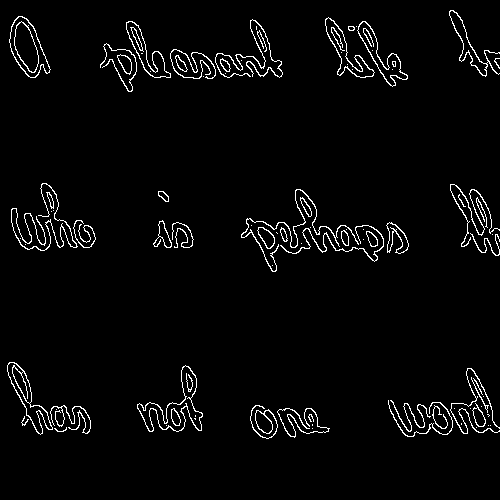

In [ ]:
keras.preprocessing.image.array_to_img(
    test_set[123]
    )

## MODEL ARCHITECTURE
Let's bring back our model architecture that we have previously trained. Then what we need to do is to load the corresponding weights from google colab and remove the classification layer. the model:
*   contained 4 convolutional layers
*   contained2 dense layers
*   and an output (classification) layer

In [ ]:
from keras import models, layers

model = models.Sequential()

################################.    1st CONVOLUTIONAL LAYER     ################################

model.add(layers.Conv2D(filters=32, input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), kernel_size=(7,7),strides=(2,2), padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(layers.BatchNormalization()) # Batch Normalisation before passing it to the next layer

################################.    2nd CONVOLUTIONAL LAYER     ################################

model.add(layers.Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(layers.BatchNormalization())

################################.    3rd CONVOLUTIONAL LAYER     ################################

model.add(layers.Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(layers.BatchNormalization())

################################.    4th CONVOLUTIONAL LAYER     ################################

model.add(layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(layers.BatchNormalization())

################################    FLATTEN, FOR DENSE LAYER     ################################

model.add(layers.Flatten())

################################.    DENSE LAYERS: 1st LAYER     ################################

model.add(layers.Dense(256, input_shape=(IMAGE_SIZE * IMAGE_SIZE * 3,)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())

################################.    DENSE LAYERS: 2nd LAYER     ################################

model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.4))
model.add(layers.BatchNormalization())


################################.    OUTPUT LAYER: CLASSES    ################################

model.add(layers.Dense(N_IDENTITY))
model.add(layers.Activation('softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

## BIOMETRIC EVALUATION

The first thing is to load the model weights from model. Then we need to create a similarity/distance matrix. 
for this reason, we considered 31 identities with 12 templates per each. So our matrix should have 372 * 372 dimension( 31 * 12 = 372).
In the rows we have probes.
Each row (we have 372 rows) is a 31 recognition operation. But in the column, we have 372 templates.

Let's load the first model weights which was related to the model with only rotation.

### FEATURE EXTRACTOR MODEL: <b>SOLO ROTATION</b>

Let's access to the last layer of feature from our model. It will be used as our feature extractor modules in order to create a feature vector from the samples.

In [ ]:
model.load_weights('/content/gdrive/MyDrive/biometric_project/model_solo_rotation/cp-0016.h5')

In [ ]:
last_feature_layer = model.get_layer(index=24).output

In [ ]:
feature_extractor = keras.Model(
    inputs = model.input,
    outputs = last_feature_layer
)

feature_extractor.compile(optimizer=keras.optimizers.Adam(0.02),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

### FEATURE VECTOR

We are going to pass the test set into our feature extractor model in order to have a prediction for each test set sample. The model predicts a feature vector for each image. 

Then we reshape the result into a list of the feature vectors in which each element in the final list is a feature vector corresponding to each sample in the dataset.

In [ ]:
fetures_test_set = feature_extractor.predict(test_set)

In [ ]:
feature_test_set = fetures_test_set.reshape(test_set.shape[0], -1)

### SIMILARITY MATRIX
To be able to perform an evaluation task we need to create a similarity/distance matrix. We considered the similarity matrix. to compare two vector similarity we have taken into consideration the two famous cosine and correlation similarities.

Let's define two functions for each method.

In [ ]:
def cosine_similarity_matrix(features):
    matrix = []
    cosine_function = lambda a,b : np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b))
    for feature in features:
        similarities = [
            cosine_function(feature, x) for x in features
        ]

        matrix.append(np.array(similarities))
    return np.array(matrix)
        


def correlation_similarity_matrix(features):
    return np.corrcoef(features)

In [ ]:
cosine_similarity       = cosine_similarity_matrix(feature_test_set)
correlation_similarity  = correlation_similarity_matrix(feature_test_set)

In [ ]:
print(cosine_similarity.shape)
print(correlation_similarity.shape)

(372, 372)
(372, 372)


Now, we have a 372 * 372 matrix that gives us the ability to perform an all-against-all evaluation task.

### IMPOSTER/GENUINE SCORES
We are going to use the pyeer library. this library is using two different scores as the input. One corresponds to imposters scores, and the other is the genuine scores.

To be able to separate those scores we have defined the following function.

In [ ]:
def separated_imposters_genuine_scores(similarity_matrix):
    genuine_scores = []
    imposter_scores = []
    for probe in range(0, similarity_matrix.shape[0]): # for each probe of the matrix ===> probe
        for identity in range(N_IDENTITY): # loop over the columns based on the identities

            identity_templates_indexes = np.arange(identity * N_TEMPLATES, (identity + 1) * N_TEMPLATES) 
            identity_templates_indexes_excluded = identity_templates_indexes[np.where(identity_templates_indexes!=probe)]
            identity_templates_scores  = similarity_matrix[probe, identity_templates_indexes_excluded]

            if(identity == probe//N_TEMPLATES):
                genuine_scores.append(identity_templates_scores)
            else:
                imposter_scores.append(identity_templates_scores)

    return np.array(genuine_scores), np.array(imposter_scores)

The function above will be used as an input for the pyeer library.

### CONFUSION MATRIX
One interesting thing to do is to create a confusion matrix from the scores which will be able to show how good a biometric system is. To create such matrix we can define very similar method from function above, but this time we split the imposter scores and genuine scores into two subset. and consider a threshold for the methods.

In [ ]:
def confusion(similarity_matrix, threshold):
    confusion_matrix = np.array([
        [0, 0], # [Genuine Match(GM, GA)     False   Non-Match(FNM, FR)]
        [0, 0]  # [False   Match(FM, FA)     Genuine Non-Match(GNM, GR)]
    ])

    for probe in range(0, similarity_matrix.shape[0]): # for each probe of the matrix ===> probe
        for identity in range(N_IDENTITY): # loop over the columns based on the identities

            # each tamplate of the identity in the matrix has a column index
            '''
                                        
                identity_0 template_0   0 1 2 3 4 5 6 7 8 9 10 11 __ 12 13 14 15 16 17 18 19 20 21 22 23 __ ... 370 371
                identity_0 template_1   0 1 2 3 4 5 6 7 8 9 10 11 __ 12 13 14 15 16 17 18 19 20 21 22 23 __ ... 370 371
                identity_0 template_3   0 1 2 3 4 5 6 7 8 9 10 11 __ 12 13 14 15 16 17 18 19 20 21 22 23 __ ... 370 371
                        .
                        .
                identity_0 template_11  0 1 2 3 4 5 6 7 8 9 10 11 __ 12 13 14 15 16 17 18 19 20 21 22 23 __ ... 370 371
                identity_1 template_0   0 1 2 3 4 5 6 7 8 9 10 11 __ 12 13 14 15 16 17 18 19 20 21 22 23 __ ... 370 371
                        .
                        .
                identity_30 template_11 0 1 2 3 4 5 6 7 8 9 10 11 __ 12 13 14 15 16 17 18 19 20 21 22 23 __ ... 370 371

            '''
            identity_templates_indexes = np.arange(identity * N_TEMPLATES, (identity + 1) * N_TEMPLATES) 
            identity_templates_indexes_excluded = identity_templates_indexes[np.where(identity_templates_indexes!=probe)]
            identity_templates_scores  = similarity_matrix[probe, identity_templates_indexes_excluded]

            if (identity_templates_scores.max() > threshold): # possible genuine acceptance
                if(identity == probe//N_TEMPLATES): # check to see whether the identity id is the same probe identity
                    confusion_matrix[0, 0] +=1    # Genuine Match or Genuine Acceptance (GM, GA)
                else:
                    confusion_matrix[1, 0] +=1.   # False Match or False Acceptance (FM, FA)
            else: # possible imposters
                if(identity == probe//N_TEMPLATES):# check to see whether the identity id is the same probe identity
                    confusion_matrix[0, 1] += 1   # False Non-Match or False Rejection (FNM, FR)
                else:
                    confusion_matrix[1, 1] += 1   # Genuine Non-Match or Genuine Rejection(GNM, GR)
        
    return confusion_matrix

In [ ]:
confusion(correlation_similarity, 0.75)

array([[  229,   143],
       [  522, 10638]])

In [ ]:
confusion(cosine_similarity, 0.75)

array([[  231,   141],
       [  612, 10548]])

In [ ]:
genuine_scores_corr, impostor_scores_corr = separated_imposters_genuine_scores(correlation_similarity)

In [ ]:
genuine_scores_sim, impostor_scores_sim = separated_imposters_genuine_scores(cosine_similarity)

In [ ]:
print(genuine_scores_corr.flatten().shape, impostor_scores_corr.flatten().shape)

(4092,) (133920,)


In [ ]:
print(genuine_scores_sim.flatten().shape, impostor_scores_sim.flatten().shape)

(4092,) (133920,)


### REPORT AND FOM (FIGURES OF MERIT)

To evaluate the system we have used the pyeer library in which we are able to perform all-against-all evaluation and plot different biometric figures.

In [ ]:
%%capture
!pip install pyeer

In [ ]:
from pyeer.eer_info import get_eer_stats
stats_corr_model_rotation = get_eer_stats(
    gen_scores = genuine_scores_corr.flatten(),
    imp_scores = impostor_scores_corr.flatten() 
)
stats_sim_model_rotation = get_eer_stats(
    gen_scores = genuine_scores_sim.flatten(),
    imp_scores = impostor_scores_sim.flatten() 
)

In [ ]:
from pyeer.plot import plot_eer_stats
plot_eer_stats(
    [stats_corr_model_rotation],
    ['model_solo_rotation_correlation'],
    line_width=2,
    save_plots=True,
    lgf_size=15,
    dpi=1000,
    bins=correlation_similarity.shape[0],
    save_path='/content/gdrive/MyDrive/biometric_project/scores/solo_rotation/correlation',
    ext='.jpeg'
)

In [ ]:
from pyeer.plot import plot_eer_stats
plot_eer_stats(
    [stats_sim_model_rotation],
    ['model_solo_rotation_similarity'],
    line_width=2,
    save_plots=True,
    lgf_size=15,
    dpi=1000,
    bins=correlation_similarity.shape[0],
    save_path='/content/gdrive/MyDrive/biometric_project/scores/solo_rotation/similarity',
    ext='.jpeg'
)

### FEATURE EXTRACTOR MODEL : <b>MORE AUGMENTATION</b>

Let's now load the second model with more augmentation options.

In [ ]:
model.load_weights('/content/gdrive/MyDrive/biometric_project/model_full_aug/cp-0018.h5')

In [ ]:
last_feature_layer = model.get_layer(index=24).output

In [ ]:
feature_extractor_full_aug = keras.Model(
    inputs = model.input,
    outputs = last_feature_layer
)

feature_extractor_full_aug.compile(optimizer=keras.optimizers.Adam(0.02),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

### FEATURE VECTOR: Second model

Like before we start extracting the features using the model extractor

In [ ]:
fetures_test_set_full_aug = feature_extractor_full_aug.predict(test_set)

In [ ]:
feature_test_set_full_aug = fetures_test_set_full_aug.reshape(test_set.shape[0], -1)

### SIMILARITY MATRIX


In [ ]:
cosine_similarity_full_aug       = cosine_similarity_matrix(feature_test_set_full_aug)
correlation_similarity_full_aug  = correlation_similarity_matrix(feature_test_set_full_aug)

In [ ]:
print(correlation_similarity_full_aug.shape)
print(cosine_similarity_full_aug.shape)

(372, 372)
(372, 372)


Now, we have a 372 * 372 matrix that gives us the ability to perform an all-against-all evaluation task.

### CONFUSION MATRIX


In [ ]:
confusion(correlation_similarity_full_aug, 0.75)

array([[  308,    64],
       [  873, 10287]])

In [ ]:
confusion(cosine_similarity_full_aug, 0.75)

array([[  340,    32],
       [  877, 10283]])

In [ ]:
genuine_scores_corr_full_aug, impostor_scores_corr_full_aug = separated_imposters_genuine_scores(correlation_similarity_full_aug)

In [ ]:
genuine_scores_sim_full_aug, impostor_scores_sim_full_aug = separated_imposters_genuine_scores(cosine_similarity_full_aug)

In [ ]:
print(genuine_scores_corr_full_aug.flatten().shape, impostor_scores_corr_full_aug.flatten().shape)

(4092,) (133920,)


In [ ]:
print(genuine_scores_sim_full_aug.flatten().shape, impostor_scores_sim_full_aug.flatten().shape)

(4092,) (133920,)


In [ ]:
from pyeer.eer_info import get_eer_stats
stats_corr_model_full_aug = get_eer_stats(
    gen_scores = genuine_scores_corr_full_aug.flatten(),
    imp_scores = impostor_scores_corr_full_aug.flatten() 
)
stats_sim_model_full_aug = get_eer_stats(
    gen_scores = genuine_scores_sim_full_aug.flatten(),
    imp_scores = impostor_scores_sim_full_aug.flatten() 
)

In [ ]:
from pyeer.plot import plot_eer_stats
plot_eer_stats(
    [stats_corr_model_full_aug],
    ['model_full_aug_correlation'],
    line_width=2,
    save_plots=True,
    lgf_size=15,
    dpi=1000,
    bins=correlation_similarity_full_aug.shape[0],
    save_path='/content/gdrive/MyDrive/biometric_project/scores/full_aug/correlation',
    ext='.jpeg'
)

In [ ]:
from pyeer.plot import plot_eer_stats
plot_eer_stats(
    [stats_sim_model_full_aug],
    ['model_full_aug_similarity'],
    line_width=2,
    save_plots=True,
    lgf_size=15,
    dpi=1000,
    bins=correlation_similarity_full_aug.shape[0],
    save_path='/content/gdrive/MyDrive/biometric_project/scores/full_aug/similarity',
    ext='.jpeg'
)

## Report


In [ ]:
from pyeer.report import generate_eer_report
generate_eer_report(
    [stats_corr_model_rotation, stats_sim_model_rotation, stats_corr_model_full_aug, stats_sim_model_full_aug], 
    ['solo_rotation_correlation', 'solo_rotation_cosine' , 'full_aug_correlation' , 'full_aug_cosine'], 
    '/content/gdrive/MyDrive/biometric_project/scores/report.html'
    )